# Writing Custom Datasets, DataLoaders and Transforms

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd 
from skimage import io, transform 
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings('ignore')

plt.ion() #interactive mode

# Dataset class

In [2]:
# 사용할 데이터:
# facial pose images 
# 68 different landmark points are annotated for each face

In [3]:
landmarks_frame = pd.read_csv('/content/drive/MyDrive/PyTorch/data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.array(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print(f'Image name: {img_name}')
print(f'Landmarks shape: {landmarks.shape}')
print(f'First 4 Landmarks: {landmarks[:4]}')

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [4]:
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [5]:
landmarks_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Columns: 137 entries, image_name to part_67_y
dtypes: int64(136), object(1)
memory usage: 74.0+ KB


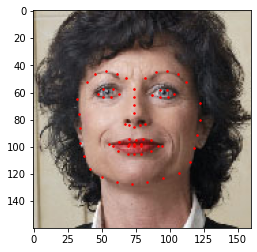

In [6]:
def show_landmarks(image, landmarks):
  """샘플 - 이미지와 랜드마크 출력"""
  plt.imshow(image)
  plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker = '.', c = 'r')
  plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('/content/drive/MyDrive/PyTorch/data/faces', img_name)), landmarks)
plt.show()

## Dataset class

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:
- _ _ len _ _ so that len(dataset) returns the size of the dataset.
- _ _ getitem _ _ to support the indexing such that dataset[i] can be used to get _i_th sample.

In [7]:
class FaceLandmarksDataset(Dataset):
  """Face Landmarks dataset."""

  # __init__ 에서 csv파일 불러오지만 이미지 리딩은 __getitem__에서: 
  # 메모리 및 속도면에서 더 효율적
  def __init__(self, csv_file, root_dir, transform=None):
    """
    Args:
        csv_file (string): 이미지별 annotation 정보 있는 csv 파일 경로
        root_dir (string): 이미지 폴더 경로
        transform (callable, optional): Optional transform to be applied on a sample
    """
    self.landmarks_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    # transform 인자 받음 -> any required processing can be applied on the sample
    self.transform = transform

  def __len__(self):
    return len(self.landmarks_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
    image = io.imread(img_name)
    landmarks = self.landmarks_frame.iloc[idx, 1:]
    landmarks = np.array([landmarks])
    landmarks = landmarks.astype('float').reshape(-1, 2)
    sample = {'image': image, 'landmarks': landmarks}

    if self.transform:
      sample = self.transform(sample)

    return sample

0 (324, 215, 3) (68, 2)


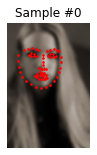

1 (500, 333, 3) (68, 2)


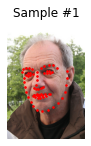

2 (250, 258, 3) (68, 2)


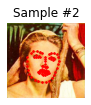

3 (434, 290, 3) (68, 2)


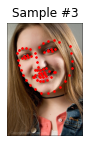

In [9]:
# initiating the class and iterating through the data samples

face_dataset = FaceLandmarksDataset(csv_file = '/content/drive/MyDrive/PyTorch/data/faces/face_landmarks.csv',
                                    root_dir = '/content/drive/MyDrive/PyTorch/data/faces')

fig = plt.figure()

for i in range(len(face_dataset)):
  sample = face_dataset[i]

  print(i, sample['image'].shape, sample['landmarks'].shape)

  ax = plt.subplot(1, 4, i+1)
  plt.tight_layout()
  ax.set_title(f'Sample #{i}')
  ax.axis('off')
  show_landmarks(**sample)
  # **sample 하면 sample의 key, value의 key값 return: **kwargs = 여기서는 'image'

  if i == 3:
    plt.show()
    break

# Transforms

One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some preprocessing code. Let's create three transforms:
- Rescale: to scale the image
- RandomCrop: to crop from image randomly. This is data augmentation.
- ToTensor: to convert the numpy images to torch images (we need to swap axes)

In [10]:
# 여긴 복붙 - 어떤 원리로 작동하는지만 이해
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose transforms

In [12]:
# We will write them as callable classes instead of simple functions 
# so that parameters of the transform need not be passed everytime it’s called. 
# For this, we just need to implement __call__ method and if required, __init__ method. 
# We can then use a transform like this:

#tsfm = Transform(params)
#transformed_sample = tsfm(sample)



scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

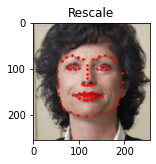

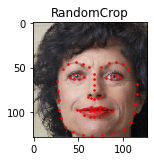

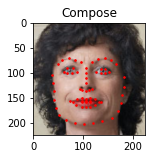

In [13]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
  transformed_sample = tsfrm(sample)

  ax = plt.subplot(1, 3, i+1)
  plt.tight_layout()
  ax.set_title(type(tsfrm).__name__)
  show_landmarks(**transformed_sample)

plt.show()

# Iterating through the dataset

Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

- An image is read from the file on the fly
- Transforms are applied on the read image
- Since one of the transforms is random, data is augmented on sampling

In [14]:
transformed_dataset = \
FaceLandmarksDataset(csv_file = '/content/drive/MyDrive/PyTorch/data/faces/face_landmarks.csv',
                     root_dir = '/content/drive/MyDrive/PyTorch/data/faces',
                     transform = transforms.Compose([
                                                     Rescale(256),
                                                     RandomCrop(224),
                                                     ToTensor()
                     ]))

for i in range(len(transformed_dataset)):
  sample = transformed_dataset[i]

  print(i, sample['image'].size(), sample['landmarks'].size())

  if i == 3:
    break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:


- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.


**torch.utils.data.DataLoader** is an iterator which provides all these features.

  - collate_fn: be used to specify how exactly the samples need to be batched. (default collate should work fine for most use cases.)

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


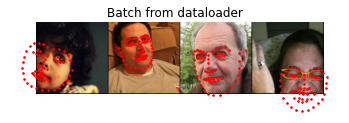

In [15]:
dataloader = DataLoader(transformed_dataset, batch_size = 4, # p for batching the data
                        shuffle = True, # p for shuffling the data
                        num_workers = 0) # p to load the data in parallel using multiprocessing workers

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
  """Show image with landmarks for a batch of samples."""
  images_batch, landmarks_batch = \
          sample_batched['image'], sample_batched['landmarks']
  batch_size = len(images_batch)
  im_size = images_batch.size(2)
  grid_border_size = 2

  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

  for i in range(batch_size):
    plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                landmarks_batch[i, :, 1].numpy() + grid_border_size,
                s=10, marker='.', c='r')

    plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change "num_workers" to 0.

if __name__ == '__main__':
  for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
      plt.figure()
      show_landmarks_batch(sample_batched)
      plt.axis('off')
      plt.ioff()
      plt.show()
      break

# Afterword : torchvision

- torchvision에서 몇가지 데이터셋과 transfroms 제공.

ImageFolder 데이터셋: 
- it assumes that images are organized in the following way:
  root/ants/xxx.png
  root/ants/xxy.jpeg
  root/ants/xxx.png
  .
  .
  .
  root/bees/123.png
  root/bees/sdfs.png
  root/bees/1sdgs_.jpg
  - 'ants', 'bees' : class labels

Genetric transforms operate on PIL.Image:
  - RandomHorizontalFlip
  - Scale

In [ ]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)